# Response to article

Predict: Upvotes, downvotes, number of comments, length of comments, ...  
Something interpretable would be nice.

See <a href="#summary">summary</a> at the end.

In [1]:
%matplotlib inline
import re
from time import time
from datetime import datetime
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df_art = pd.read_csv('articles_2017_09.csv')
df_com = pd.read_csv('comments_2017_09.csv')


In [2]:
def get_dt_obj(time):
    time = time.replace('am ', '')
    # Make datetime object from string
    return datetime.strptime(time, '%d.%m.%Y %H:%M')

def time_since_epoch(time):
    return ((time)-datetime(1970,1,1)).total_seconds()

def get_hour_of_day(time):
    return (time).hour

def get_weekday(time):
    return (time).weekday()

df_com['time_dt'] = df_com['time'].apply(get_dt_obj)
df_com['time_since_epoch'] = df_com['time_dt'].apply(time_since_epoch)
df_com['hour'] = df_com['time_dt'].apply(get_hour_of_day)
df_com['weekday'] = df_com['time_dt'].apply(get_weekday) # 0 = Monday
df_com['is_answer'] = df_com['tit'].apply(lambda x: str(x).startswith('@'))
#df_com['con_len'] = df_com['con'].apply(len)
#df_com['con_num_words'] = df_com['con'].apply(lambda x: len(x.split()))
df_com['score'] = df_com['vup'] - df_com['vdo']
df_com['activity'] = df_com['vup'] + df_com['vdo']

df_com['tit'] = df_com['tit'].str.lower()
df_com['con'] = df_com['con'].str.lower()

def get_category(link):
    t = link.split('/')
    if len(t) <= 1:
        return ''
    else:
        return t[1]

df_art['cat'] = df_art['link'].apply(get_category)
df_art['cat_copy'] = df_art['cat']
df_art = pd.get_dummies(df_art, columns=['cat'])

#df_art['header'] = df_art['header'].str.lower()
#df_art['sub'] = df_art['sub'].str.lower()
#df_art['text'] = df_art['text'].str.lower()
df_art['header_len'] = df_art['header'].apply(len)
df_art['sub_len'] = df_art['sub'].apply(lambda x: len(str(x)))
df_art['text_len'] = df_art['text'].apply(lambda x: len(str(x)))
df_art['text_num_words'] = df_art['text'].apply(lambda x: len(str(x).split()))
df_art['text_n_periods'] = df_art['text'].apply(lambda x: len(str(x).split('.')))

# Left inner join
df_merge = pd.merge(left=df_com[['tId', 'score', 'activity', 'time_since_epoch', 'weekday', 'hour']], right=df_art, left_on='tId', right_on='tId')

# Remove rows with missing values
# use .count() to check for missing values
df_merge.dropna(axis=0, how='any', inplace=True)

# Get order of comments per article
df_merge = df_merge.sort_values(['tId', 'time_since_epoch']).groupby('tId')

# Get article specific statistics, group = article
def get_art_statistics(group):
    first = group.iloc[:1]['time_since_epoch']
    group['art_first_weekday'] = group.iloc[:1]['weekday']
    group['art_first_hour'] = group.iloc[:1]['hour']

    group['time_since_first'] = group['time_since_epoch'].apply(lambda x: (x - first) / 3600)

    group['art_score_sum'] = group['score'].sum()
    group['art_activity_sum'] = group['activity'].sum()
    
    return group

df_merge = df_merge.apply(get_art_statistics)
df_merge = df_merge.groupby('tId').mean().reset_index()
df_merge = df_merge.merge(df_art[['tId', 'header', 'sub', 'text']], on='tId')
df_merge.head(2)[['score', 'num_comments']]

,score,num_comments
0,110.904762,21.0
1,49.123288,73.0


In [49]:
# Prepare data

#temp2 = pd.get_dummies(df_merge[['tId', 'art_first_weekday']], prefix='art_wd_', columns=['art_first_weekday'])
# Merge here first because of index!
#df = df_merge.merge(temp2, on='tId') 
df = pd.get_dummies(df_merge, columns=['art_first_weekday'])

# Unused categories, drop them
df = df.drop(['cat_playview', 'cat_play'], axis=1)

# https://de.wikipedia.org/wiki/Liste_der_h%C3%A4ufigsten_W%C3%B6rter_der_deutschen_Sprache
stop_words = "die, der, und, in, zu, den, das, nicht, von, sie, ist, des, sich, mit, dem, dass, er, es, ein, ich, auf, so, eine, auch, als, an, nach, wie, im, für, "
stop_words += "man, aber, aus, durch, wenn, nur, war, noch, werden, bei, hat, wir, was, wird, sein, einen, welche, sind, oder, zur, um, haben, einer, mir, über, ihm, diese, einem, ihr, uns, "
stop_words += "da, zum, kann, doch, vor, dieser, mich, ihn, du, hatte, seine, mehr, am, denn, nun, unter, sehr, selbst, schon, hier, im,"
stop_words += "bis, habe, ihre, dann, ihnen, seiner, alle, wieder, meine, Zeit, gegen, vom, ganz, einzelnen, wo, muss, ohne, eines, können, sei"
stop_words = stop_words.lower().split(', ')

# add text features: text -> tfidf -> TruncatedSVD -> feed to models -> X
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# not sure if I have to reintialize the Vectorizer and SVD every time to reset
vect = TfidfVectorizer(stop_words=stop_words, min_df=3, max_df=0.6)
res = vect.fit_transform(df[['header']].values.ravel())
svd = TruncatedSVD(n_components=30, n_iter=7)
res = svd.fit_transform(res)
res = pd.DataFrame(res).add_prefix('svd_header_')
df = pd.concat([df, res], axis=1)

vect = TfidfVectorizer(stop_words=stop_words, min_df=3, max_df=0.6)
res = vect.fit_transform(df[['sub']].values.ravel())
svd = TruncatedSVD(n_components=30, n_iter=7)
res = svd.fit_transform(res)
res = pd.DataFrame(res).add_prefix('svd_sub_')
df = pd.concat([df, res], axis=1)

vect = TfidfVectorizer(stop_words=stop_words, min_df=3, max_df=0.6)
res = vect.fit_transform(df[['text']].values.ravel())
svd = TruncatedSVD(n_components=30, n_iter=7)
res = svd.fit_transform(res)
res = pd.DataFrame(res).add_prefix('svd_text_')
df = pd.concat([df, res], axis=1)

# Memory optimization
# Technical stuff, contributes nothing to analysis
conv = df.select_dtypes(include=['int', 'float']).apply(pd.to_numeric,downcast='unsigned')
df[conv.columns] = conv
    
# Get pearson co-efficients
df.corr()
#df.info()
#colormap = plt.cm.viridis
#plt.figure(figsize=(12,12))
#plt.title('Pearson Correlation of Features', y=1.05, size=15)
#sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)


,tId,score,activity,time_since_epoch,weekday,hour,article_id,updated,num_comments,cat_ausland,...,svd_text_20,svd_text_21,svd_text_22,svd_text_23,svd_text_24,svd_text_25,svd_text_26,svd_text_27,svd_text_28,svd_text_29
tId,1.000000,0.002489,-0.012417,-0.027862,0.007069,-0.022099,0.997714,0.010961,-0.010061,-0.012343,...,-0.020246,0.007194,2.206413e-02,-0.002750,-2.127790e-02,-2.063395e-02,-0.031879,7.129141e-03,-0.007025,-2.962374e-02
score,0.002489,1.000000,0.792733,0.033427,-0.002571,0.065504,0.001628,-0.019505,-0.003332,0.049031,...,-0.000718,-0.039048,-4.373166e-02,-0.008799,-3.631248e-02,3.864324e-02,0.033078,-3.789591e-02,-0.052538,1.456781e-02
activity,-0.012417,0.792733,1.000000,0.045888,0.029045,0.086315,-0.013447,-0.025012,0.008002,0.103206,...,-0.004259,-0.044350,-3.685059e-02,0.008265,-2.377883e-02,4.751009e-02,0.044907,-1.523297e-02,-0.067454,4.580995e-02
time_since_epoch,-0.027862,0.033427,0.045888,1.000000,0.020684,0.030757,-0.027450,0.100234,0.042488,0.037357,...,0.063443,-0.065267,-1.987502e-02,0.032021,4.205285e-02,8.584188e-03,-0.028710,-2.525492e-02,-0.035578,-2.912909e-04
weekday,0.007069,-0.002571,0.029045,0.020684,1.000000,0.058002,0.009173,-0.025130,0.035074,0.003723,...,0.000663,0.028435,7.826307e-03,-0.014179,-8.035606e-04,-2.085537e-02,0.002377,7.864694e-03,0.008306,1.612684e-02
hour,-0.022099,0.065504,0.086315,0.030757,0.058002,1.000000,-0.020774,0.022068,-0.034452,-0.008135,...,-0.024512,0.097060,1.042086e-02,-0.005795,-2.967508e-02,1.025949e-02,-0.024832,-3.086902e-02,-0.030936,-2.159761e-02
article_id,0.997714,0.001628,-0.013447,-0.027450,0.009173,-0.020774,1.000000,0.014333,-0.007248,-0.013784,...,-0.015511,0.007146,2.755220e-02,-0.003578,-2.333278e-02,-2.426271e-02,-0.032096,6.957326e-03,-0.009754,-2.799748e-02
updated,0.010961,-0.019505,-0.025012,0.100234,-0.025130,0.022068,0.014333,1.000000,-0.019521,-0.020738,...,-0.028409,-0.013862,-2.648206e-02,-0.004247,1.237858e-02,-3.009574e-02,0.001486,6.499047e-02,-0.008315,3.183586e-02
num_comments,-0.010061,-0.003332,0.008002,0.042488,0.035074,-0.034452,-0.007248,-0.019521,1.000000,-0.008711,...,0.117164,0.003782,-6.331616e-02,0.105176,-5.401113e-02,7.302930e-02,-0.001074,-1.070161e-02,0.005561,9.795286e-03
cat_ausland,-0.012343,0.049031,0.103206,0.037357,0.003723,-0.008135,-0.013784,-0.020738,-0.008711,1.000000,...,0.016437,0.008845,-2.377978e-02,-0.007060,2.808274e-02,1.812151e-02,0.086587,3.393241e-02,-0.066228,1.719219e-02


In [50]:
# Do splits

# Drop everything related to comments
df2 = df.drop(['score', 'activity', 'num_comments', #'mob', 'vup', 'vdo',
                'art_score_sum', 'art_activity_sum', 'weekday', 'hour', #'con_len', 'con_num_words', 'is_answer',
               # remove text columns
              'text', 'header', 'sub'], axis=1)
X = df2
y = df['num_comments']
#y = df['con_len']
#y = df['vup']

from sklearn.model_selection import train_test_split, learning_curve
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print("total data: ", len(X))

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=None, params=None):
        if seed is not None: params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        return (self.clf.fit(x,y).feature_importances_)

def get_oof(clf):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(X_test)):
        x_tr = X_train.values[train_index]
        y_tr = y_train.values[train_index]
        x_te = X_train.values[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(X_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

from sklearn.model_selection import KFold;
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 3 # set folds for out-of-fold prediction
kf = KFold(n_splits=NFOLDS, random_state=SEED)

#X.info()

total data:  2637


In [75]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

# Put in our parameters for said classifiers
# Random Forest parameters
n_estimators = 500   # was 500
rf_params = {
    'n_jobs': -1,
    'n_estimators': n_estimators,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': n_estimators,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 3,
    'verbose': 1
}

# AdaBoost parameters
ada_params = {
    'n_estimators': n_estimators,
    'learning_rate' : 0.6
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': n_estimators,
     #'max_features': 0.2,
    'max_depth': 4,
    'min_samples_leaf': 3,
    'verbose': 1
}

# Support Vector Classifier parameters
# - training is very slow, use approximation of kernel matrix?
svr_params = {
    'kernel' : 'linear',
    'C' : 0.025
}

# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestRegressor, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesRegressor, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostRegressor, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingRegressor, seed=SEED, params=gb_params)
#svr = SklearnHelper(clf=SVR, params=svr_params) # SVR has no "random_state"

# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb) # Gradient Boost
#svr_oof_train, svr_oof_test = get_oof(svr) # Support Vector Classifier

print("Training is complete.")

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapse

      Iter       Train Loss   Remaining Time 
         1       16781.3057            4.43s
         2       15543.4480            5.57s
         3       14056.6770            4.85s
         4       13116.5639            4.42s
         5       12333.9066            4.10s
         6       11408.8456            3.97s
         7       10819.5748            3.79s
         8       10113.7555            3.66s
         9        9640.0294            3.62s
        10        9073.1924            3.53s
        20        5453.7171            3.42s
        30        3755.1618            3.28s
        40        2666.1898            3.39s
        50        1945.9099            3.55s
        60        1502.7686            3.58s
        70        1142.4050            3.40s
        80         853.3813            3.24s
        90         699.4683            3.08s
       100         578.6990            3.00s
       200          55.2750            2.30s
       300           5.3383            1.49s
       40

In [76]:
# CV grid search
from sklearn.model_selection import GridSearchCV

if False:
    rf_params = {
         #'warm_start': [True, False], 
        'max_depth': [4, 5, 6, 7],
        'min_samples_leaf': [2, 3, 4],
        #'max_features' : ['sqrt', 'auto', 'log2'],
        #'n_estimators': [500, 600, 700]
    }
    et_params = {
        #'n_estimators': [400, 500, 600],
        'max_depth': [7, 8, 9],
        'min_samples_leaf': [1, 2, 3],
        'verbose': [0, 1],
        'warm_start': [True, False]
    }
    ada_params = {
        #'n_estimators': n_estimators,
        'learning_rate' : [0.5, 0.6, 0.75, 0.9, 1]
    }
    gb_params = {
        #'n_estimators': n_estimators,
         #'max_features': 0.2,
        'max_depth': [4, 5, 6],
        'min_samples_leaf': [1, 2, 3],
        'verbose': [0, 1]
    }
    
    #grid = GridSearchCV(RandomForestRegressor(), rf_params)
    #grid = GridSearchCV(ExtraTreesRegressor(), et_params)
    #grid = GridSearchCV(AdaBoostRegressor(), ada_params)
    grid = GridSearchCV(GradientBoostingRegressor(), gb_params)
    
    grid.fit(X_train, y_train)
    print(grid.best_params_)
    

In [77]:
rf_feature = (rf.feature_importances(X_train,y_train))
et_feature = (et.feature_importances(X_train, y_train))
ada_feature = (ada.feature_importances(X_train, y_train))
gb_feature = (gb.feature_importances(X_train,y_train))

cols = X_train.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })

# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
#print(feature_dataframe.head(3))

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.5s finished


      Iter       Train Loss   Remaining Time 
         1       23165.5608           20.71s
         2       22012.1970           21.27s
         3       20884.4958           19.95s
         4       19946.9821           18.11s
         5       19124.2012           18.77s
         6       18323.7977           19.95s
         7       17710.3590           19.71s
         8       17128.9847           19.80s
         9       16468.5862           19.95s
        10       16054.2818           19.93s
        20       12875.6371           16.97s
        30       10606.9608           15.74s
        40        8955.8561           17.15s
        50        7919.0342           17.45s
        60        7021.7597           16.26s
        70        6460.3500           15.74s
        80        5677.4061           16.02s
        90        5167.3776           15.80s
       100        4748.3967           15.23s
       200        1779.5298           10.95s
       300         665.5997            6.68s
       40

In [78]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
#print(base_predictions_train.head())

data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Portland',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

# Less correlation is better

In [80]:
#x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svr_oof_train), axis=1)
#x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svr_oof_test), axis=1)
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test), axis=1)

gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 500, # was 2000
 max_depth= 4, # was 4
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'linear:regression',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

R^2: -0.11
Explained var: 0.017485
Mean absolute err: 89.45
Mean squared err: 24747.16


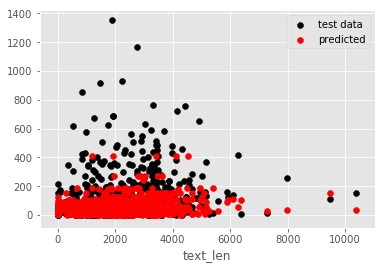

In [81]:
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error

y_pred = predictions
print("R^2: %1.2f" % r2_score(y_test, y_pred))
print("Explained var: {:3f}".format(explained_variance_score(y_test, y_pred)))
print("Mean absolute err: {:.2f}".format(mean_absolute_error(y_test, y_pred)))
print("Mean squared err: {:.2f}".format(mean_squared_error(y_test, y_pred)))

# Residual plot
X_res = X_test['text_len']
plt.scatter(X_res, y_test, color='black', label='test data')
plt.scatter(X_res, y_pred, color='red', label='predicted')
plt.xlabel('text_len')
plt.legend(); plt.show()

### Summary
<a id="summary"></a>

In this case we did not use words at all, but text statistics. The score was a bit worse.

Observations:
 * tfidf vectorizer only helped a bit
 * the stacked learners are not doing as good as a simple linear regressor
 * grid search cv for first stage learners helped a little bit
 